In [1]:
# External Dependencies

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.linalg import solve
from scipy.spatial import distance_matrix
from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull

import pylops
from pylops.utils.wavelets import ricker

import gstools as gs

from skimage.metrics import structural_similarity as ssim

C:\Users\cco\AppData\Local\Temp\ipykernel_37756\714068512.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


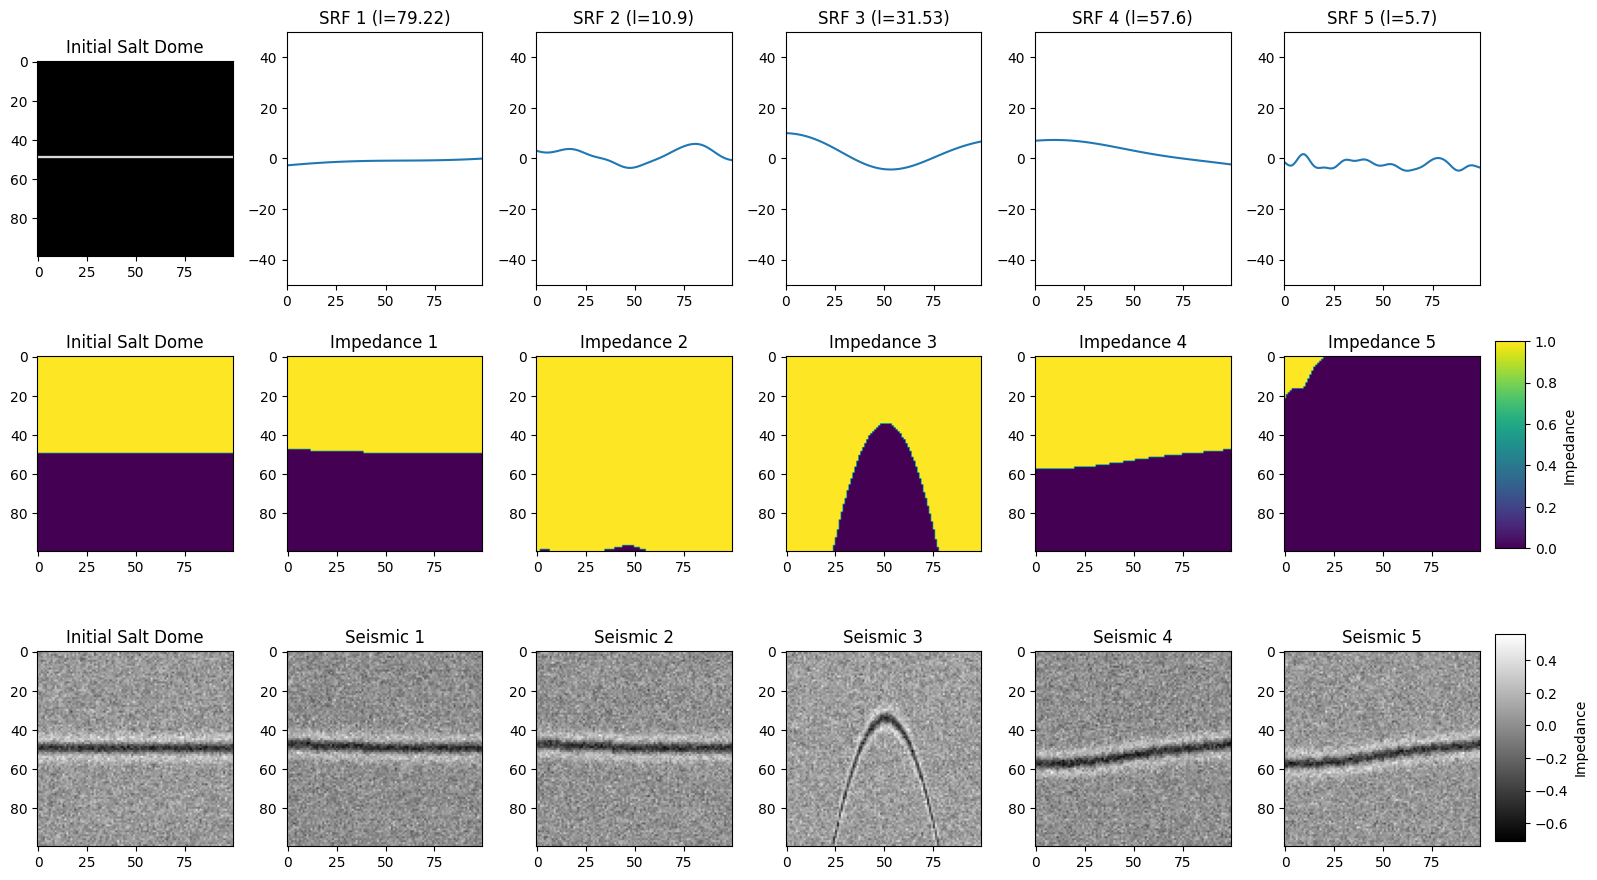

In [5]:
# TRAINING DATA GENERATION

# Impedances and corresponding seismic

# Grid constants
nx, nz = 100, 100  # Grid size in nx (n, offset) and z (depth) directions
x = np.linspace(0, nx-1, nx)
z = np.linspace(0, -(nx-1), nz)

# Impedance values
salt_impedance = 1
rock_impedance = 0

# Wavelet
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0) * dt0
ntwav = 41
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 20)

# PyLops dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True
)

# PyLops lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)

# Initial structures, activate/deactivate as needed
initial_structure = np.full((nz, nx), rock_impedance)
structure_depth = 50
structure_radius = 10
for i in range(nz):
    for j in range(nx):
        # Flat shape
        depth = structure_depth
        if i < depth:
            initial_structure[i, j] = salt_impedance
        ## Dipping shape
        #depth = structure_depth + j*0.5
        #if i < depth:
        #   initial_structure[i, j] = salt_impedance
        ## Parabolic shape
        #depth = structure_depth + (j - nx // 2)**2 / (2 * structure_radius)
        #if i < depth:
        #   initial_structure[i, j] = salt_impedance


# Shift and substraction of initial structure to obtain the structure boundary
initial_structure_temp = np.zeros((nz, nx))
initial_structure_temp[0:nz-1, :] = initial_structure[1:, :]
initial_structure_boundary = initial_structure - initial_structure_temp
initial_structure_boundary[nz-1, :] = 0

# Initial seismic data for the initial structure
initial_mi = initial_structure
initial_di = (PPop_dense * initial_mi.ravel()).reshape(nz, nx)
initial_ni = np.random.normal(0, 1e-1, initial_di.shape)
initial_dn = initial_di + initial_ni

# Lists for data preparation
num_realizations = 500
realizations_impedance = []
realizations_seismic = []
realizations_SRF = []
len_sc_list = []

# Variogram parameters
variance = 10
len_min = 1
len_max = 100


# Generation of Structures


for i in range(num_realizations):

    #### Flat structures

    # Run SRF with added initial structure as the base
    len_sc = np.random.uniform(len_min , len_max)
    model = gs.Gaussian(dim=1, var=variance, len_scale=len_sc)
    srf = gs.SRF(model)
    simulated_realization = srf((np.linspace(0, nx-1, nx)), mesh_type="structured")# + initial_salt_dome
    realizations_SRF.append(simulated_realization)

    # Structure and perturbation
    boundary_depth = 50
    perturbed_salt_dome = np.full((nz, nx), rock_impedance)
    perturbed_depth = boundary_depth + simulated_realization
    for i in range(nz):
        for j in range(nx):
            depth = perturbed_depth[j]
            if i < depth:
                perturbed_salt_dome[i, j] = salt_impedance

    # Append impedance realization and corresponding lenght
    realizations_impedance.append(perturbed_salt_dome)
    len_sc_list.append(len_sc)
  
    # Corresponding seismic data
    m = perturbed_salt_dome
    # data
    d = (PPop_dense * m.ravel()).reshape(nz, nx)
    n = np.random.normal(0, 1e-1, d.shape)
    dn = d + n

    # Append seismic realization
    realizations_seismic.append(dn)


    #### Dipping structures

    # Run SRF with added initial structure as the base
    len_sc = np.random.uniform(len_min , len_max)
    model = gs.Gaussian(dim=1, var=variance, len_scale=len_sc)
    srf = gs.SRF(model)
    simulated_realization = srf((np.linspace(0, nx-1, nx)), mesh_type="structured")# + initial_salt_dome
    realizations_SRF.append(simulated_realization)

    # Structure and perturbation
    perturbed_dipping_structure = np.full((nz, nx), rock_impedance)
    perturbed_depth = np.zeros((nx))
    depth = np.random.uniform(1, 100)
    dip = np.random.uniform(-1, 1)
    for j in range(nx):
        perturbed_depth[j] = depth + j*dip  # Dipping shape
    perturbed_depth = perturbed_depth + simulated_realization
    for i in range(nz):
        for j in range(nx):
            depth = perturbed_depth[j]
            if i < depth:
                perturbed_dipping_structure[i, j] = salt_impedance


    # Append impedance realization and corresponding lenght
    realizations_impedance.append(perturbed_dipping_structure)
    len_sc_list.append(len_sc)
  
    # Corresponding seismic data
    m = perturbed_salt_dome
    # data
    d = (PPop_dense * m.ravel()).reshape(nz, nx)
    n = np.random.normal(0, 1e-1, d.shape)
    dn = d + n

    # Append seismic realization
    realizations_seismic.append(dn)


    ##### Dome structuress

    # Run SRF with added initial structure as the base
    len_sc = np.random.uniform(len_min , len_max)
    model = gs.Gaussian(dim=1, var=variance, len_scale=len_sc)
    srf = gs.SRF(model)
    simulated_realization = srf((np.linspace(0, nx-1, nx)), mesh_type="structured")# + initial_salt_dome
    realizations_SRF.append(simulated_realization)

    # Structure and perturbation
    perturbed_salt_dome = np.full((nz, nx), rock_impedance)
    perturbed_depth = np.zeros((nx))
    dome_depth = np.random.uniform(20, 80)
    dome_radius = np.random.uniform(5, 50)
    for j in range(nx):
        perturbed_depth[j] = dome_depth + (j - nx // 2)**2 / (2 * dome_radius)
    perturbed_depth = perturbed_depth + simulated_realization
    for i in range(nz):
        for j in range(nx):
            depth = perturbed_depth[j]
            if i < depth:
                perturbed_salt_dome[i, j] = salt_impedance

    # Append impedance realization and corresponding lenght
    realizations_impedance.append(perturbed_salt_dome)
    len_sc_list.append(len_sc)
  
    # Corresponding seismic data
    m = perturbed_salt_dome
    # data
    d = (PPop_dense * m.ravel()).reshape(nz, nx)
    n = np.random.normal(0, 1e-1, d.shape)
    dn = d + n

    # Append seismic realization
    realizations_seismic.append(dn)


# Plots

fig, axes = plt.subplots(3, 5 + 1, figsize=(15, 9))

# First row, SRF perturbations
axes[0, 0].imshow(initial_structure_boundary, cmap="gray")
axes[0, 0].set_title("Initial Salt Dome")

for i, realization in enumerate(realizations_SRF[0:5]):
    axes[0, i+1].plot(realization)
    axes[0, i+1].margins(0)
    axes[0, i+1].set_title(f"SRF {i+1} (l={round(len_sc_list[i],2)})")
    axes[0, i+1].set_ylim(-50, 50)

# Second row, impedance realizations
axes[1, 0].imshow(initial_structure, cmap="viridis")
axes[1, 0].set_title("Initial Salt Dome")

for i in range (5):
    axes[1, i+1].imshow(realizations_impedance[i], cmap="viridis")
    axes[1, i+1].set_title(f"Impedance {i+1}")

# Third row, seismic realizations
axes[2, 0].imshow(initial_dn, cmap="gray")
axes[2, 0].set_title("Initial Salt Dome")

for i, realization in enumerate(realizations_seismic[0:5]):
    axes[2, i+1].imshow(realization, cmap="gray")
    axes[2, i+1].set_title(f"Seismic {i+1}")

# Colorbar for impedance
cbar_ax_imp = fig.add_axes([1.0, 0.385, 0.02, 0.23])  # [left, bottom, width, height]
cbar_imp = fig.colorbar(axes[1, 1].images[0], cax=cbar_ax_imp, orientation='vertical')
cbar_imp.set_label('Impedance')

# Colorbar for seismic
cbar_ax_seis = fig.add_axes([1.0, 0.06, 0.02, 0.23])  # [left, bottom, width, height]
cbar_imp = fig.colorbar(axes[2, 1].images[0], cax=cbar_ax_seis, orientation='vertical')
cbar_imp.set_label('Impedance')

plt.tight_layout()
plt.show() 

In [11]:
# Save data

np.save('realizations_impedance.npy', np.array(realizations_impedance))
np.save('realizations_seismic', np.array(realizations_seismic))
np.save('realizations_SRF', np.array(realizations_SRF))
np.save('len_sc_list', np.array(len_sc_list))